# Load data

In [1]:
import pandas as pd

data_fraud = pd.read_csv('data/data_fraud_final.csv')

In [2]:
data_fraud.head()

,TransactionDT,TransactionAmt,card1,card2,addr1,C3,C5,C7,C9,C14,...,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com,P_emaildomain_nan,M1_nan,M3_T,M6_T,M6_nan,isFraud
0,86400.0,68.5,13926.0,384.313069,315.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,86401.0,29.0,2755.0,404.000000,325.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,86469.0,59.0,4663.0,490.000000,330.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,86499.0,50.0,18132.0,567.000000,476.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,86506.0,50.0,4497.0,514.000000,420.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [3]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

data_fraud_sampled = data_fraud.sample(frac=0.1, random_state=42)

X, y = data_fraud_sampled.drop('isFraud', axis=1), data_fraud_sampled['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

print('Original train dataset shape {}'.format(Counter(y_train)))
print('Resampled train dataset shape {}'.format(Counter(y_train_res)))
print('Test dataset shape {}'.format(Counter(y_test)))

Original train dataset shape Counter({0.0: 45581, 1.0: 1662})
Resampled train dataset shape Counter({0.0: 45581, 1.0: 45451})
Test dataset shape Counter({0.0: 11364, 1.0: 447})


# Training

## Without hyperparametrization

In [4]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

dict_models = {
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500)
}

In [5]:
from utils import model_evaluation_clf
from time import time
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC", "Training Time (s)"])
models = {}
models_res = {}


for i, model_name in enumerate(dict_models.keys()):
    print('Training', model_name, end=' => ')

    model = dict_models[model_name]
    model_res = deepcopy(model)

    start_time = time()
    model.fit(X_train, y_train)
    end_time = time()

    start_time_res = time()
    model_res.fit(X_train_res, y_train_res)
    end_time_res = time()

    models[model_name] = model
    models_res[model_name + ' (res)'] = model_res

    eval = model_evaluation_clf(model, X_test, y_test)
    eval_res = model_evaluation_clf(model_res, X_test, y_test)

    results.loc[2*i] = [model_name, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc'], round(end_time - start_time, 1)]
    results.loc[2*i+1] = [model_name + ' (res)', eval_res['accuracy'], eval_res['precision'], eval_res['recall'], eval_res['f1'], eval_res['roc_auc'], round(end_time_res - start_time_res, 1)]

    print(f"{round(sum([end_time - start_time, end_time_res - start_time_res]), 1)}s")

Training Naive Bayes => 0.2s
Training Decision Tree => 4.1s
Training Random Forest => 25.8s
Training Gradient Boosting => 92.3s
Training Logistic Regression => 12.7s


In [6]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

                    Model  Accuracy  Precision  Recall  f1-score   AUC  Training Time (s)
            Decision Tree     0.957      0.434   0.432     0.433 0.705                1.4
      Decision Tree (res)     0.950      0.358   0.394     0.375 0.683                2.7
        Naive Bayes (res)     0.771      0.093   0.575     0.159 0.677                0.1
      Random Forest (res)     0.973      0.893   0.338     0.490 0.668               18.5
  Gradient Boosting (res)     0.966      0.590   0.338     0.430 0.664               74.3
              Naive Bayes     0.773      0.089   0.539     0.152 0.661                0.1
            Random Forest     0.973      0.919   0.306     0.460 0.653                7.3
Logistic Regression (res)     0.491      0.054   0.758     0.101 0.619                8.6
        Gradient Boosting     0.969      0.837   0.230     0.361 0.614               18.0
      Logistic Regression     0.962      0.000   0.000     0.000 0.500                4.1


## With hyperparametrization

We had better results with the resampled data. For the hyperparametrization we only considered the resampled dataset.

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf' : 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=42),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__max_depth': [3, 4, 5],
        },
    },

    {
        'name_clf' : 'Naive Bayes',
        'model': BernoulliNB(),
        'scalers' : {
            'scaler' : [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__alpha': [10**k for k in range(-5, 6)],
        },
    },

    {
        'name_clf' : 'Logistic Regression',
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__C': [0.1, 1, 10],
        },
    },

    {
        'name_clf' : 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'scalers' : {
            'scaler': [None],
        },
        'classifier__max_features': [1, 2, 3],
        'grid' : {
            'model__max_depth': list(range(1, nb_col + 1)),
        },
    },

    {
        'name_clf' : 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__max_depth': list(range(1, nb_col + 1, 5)),
        },    
    },


]

The data is shuffled with the sample (frac=1) so we have eliminated every tendancy. Finding the best parameters alreday require a lot of time because of the high amount of data and the use of a cross validation is useless thanks to the shuffle. We choose not to use any cross validation.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
from utils import model_evaluation_clf

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    print(f'Training {model_name}...')

    model = dict_clf['model']

    steps = [
        ('scaler', None),
        ('model', model),
    ]

    pipeline = Pipeline(steps)

    param_grid = {
        **dict_clf['scalers'],
        **dict_clf['grid']
    }

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

    start_time = time()
    clf.fit(X_train_res, y_train_res)
    end_time = time()
    
    print(f"Best params {model_name}: \n{clf.best_params_}")

    eval = model_evaluation_clf(clf, X_test, y_test)
    
    models[model_name] = clf

    results.loc[nb_res] = [model_name, round(end_time - start_time, 1), eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc']]
    nb_res += 1

    print(f"CPU Time: {round(end_time - start_time, 1)}s")
    print()

Training Gradient Boosting...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params Gradient Boosting: 
{'model__max_depth': 5, 'scaler': None}
CPU Time: 258.6s

Training Naive Bayes...
Fitting 5 folds for each of 33 candidates, totalling 165 fits
Best params Naive Bayes: 
{'model__alpha': 1e-05, 'scaler': MinMaxScaler()}
CPU Time: 31.6s

Training Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/celien/miniconda3/envs/ml_venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/celien/miniconda3/envs/ml_venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Best params Logistic Regression: 
{'model__C': 1, 'scaler': None}
CPU Time: 75.2s

Training Decision Tree...
Fitting 5 folds for each of 124 candidates, totalling 620 fits
Best params Decision Tree: 
{'model__max_depth': 15, 'scaler': None}
CPU Time: 152.9s

Training Random Forest...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params Random Forest: 
{'model__max_depth': 26, 'scaler': None}
CPU Time: 108.3s



In [16]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

              Model  CPU time  Accuracy  Precision  Recall  f1-score   AUC
      Decision Tree     152.9     0.960      0.474   0.405     0.437 0.694
        Naive Bayes      31.6     0.771      0.095   0.595     0.164 0.687
  Gradient Boosting     258.6     0.971      0.724   0.358     0.479 0.676
      Random Forest     108.3     0.973      0.891   0.329     0.480 0.664
Logistic Regression      75.2     0.496      0.054   0.747     0.101 0.617


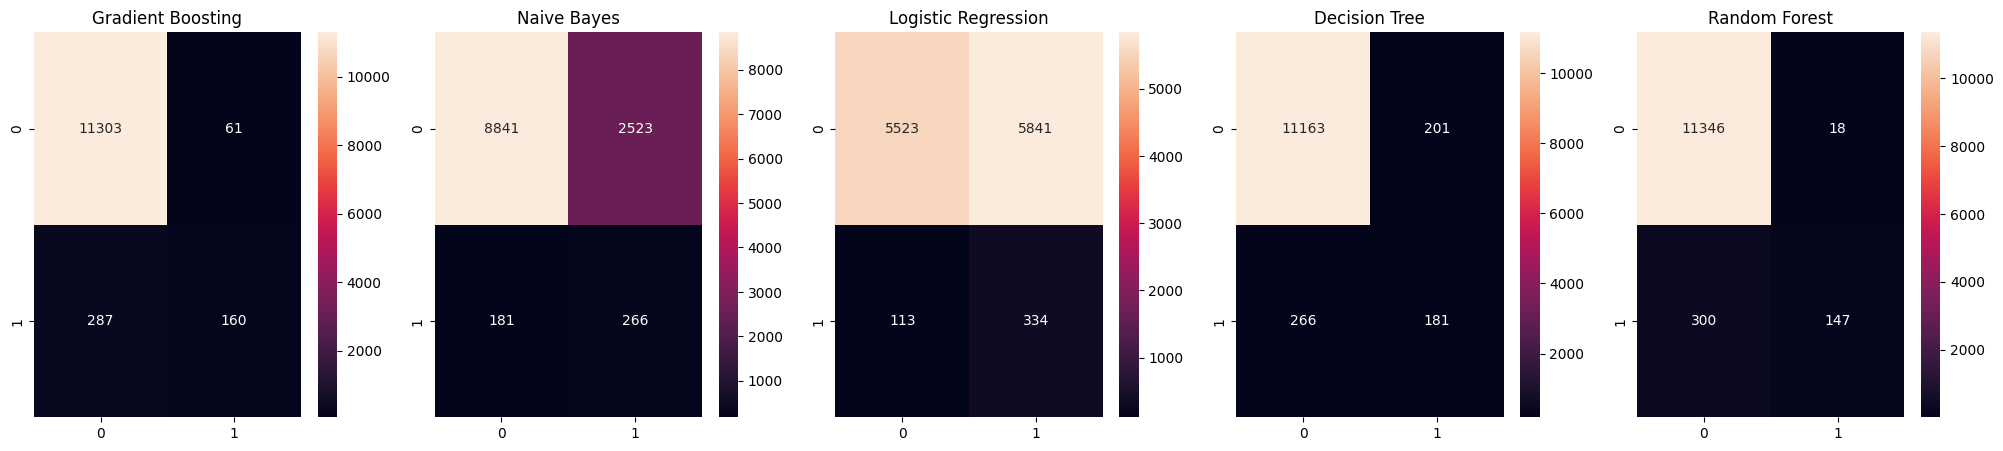

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(model_name)

plt.show()

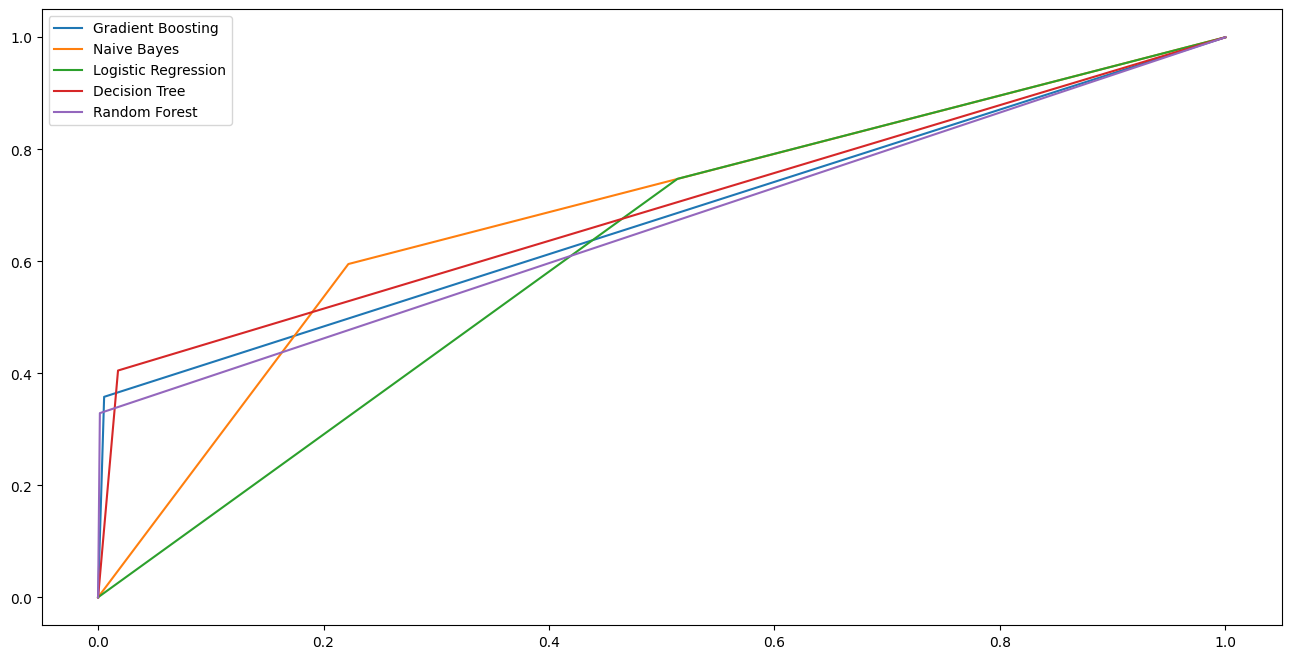

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(16, 8))

for model_name in models.keys():
    model = models[model_name]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)

plt.legend()
plt.show()


The roc curves show that except K-NN and decision tree, the models have a low rate of false positives and a high of true positives.